In [5]:
import numpy as np
import pandas as pd
# from GRNN import GRNN, calculate_error_cost
from gtm_steps import MultiLabelGTM
from scipy import stats
from scipy.optimize import differential_evolution
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge

In [6]:
class ModelStrategy(object):
    def __init__(self, regressor) -> None:
        self._strategy = regressor
        self._regressors = []

    def get_strategy(self):
        return self._strategy

    def get_regressors(self):
        return self._regressors

    def set_strategy(self, regressor) -> None:
        self._strategy = regressor

    def fit(self, X_train, Y_train) -> None:
        for y_train in Y_train.T:
            regressor = clone(self._strategy, safe=True)
            # Fit and save all regressors
            regressor.fit(X_train, y_train)
            self._regressors.append(regressor)

    def fit_transform(self, X_train, Y_train):
        y_train_pred = []
        for y_train in Y_train.T:
            regressor = clone(self._strategy, safe=True)
            # Fit and save all regressors
            regressor.fit(X_train, y_train)
            self._regressors.append(regressor)
            # Predict and save prediction for future use
            y_train_pred.append(regressor.predict(X_train))

        # Transfrom data to numpy array and return
        return np.stack(y_train_pred, axis=1)

    def transform(self, X):
        y_pred = []
        for regressor in self._regressors:
            # For each saved regressor predict an output value
            y_pred.append(regressor.predict(X))
        return np.stack(y_pred, axis=1)

class AdapterSGTM(object):
    def __init__(self, number_of_steps = 1000, verbose=0):
        self._gtm = MultiLabelGTM(number_of_steps = number_of_steps, center_of_mass = True, verbose=verbose)

    def fit(self, X_train) -> None:
        self._gtm.fit(X_train, X_train)

    def fit_transform(self, X_train):
        self._gtm.fit(X_train, X_train)
        return self._gtm.predict(X_train)

    def transform(self, X):
        return self._gtm.predict(X)


def relative_root_mean_squared_error(y, y_pred):
    n = len(y) # update
    num = np.sum(np.square(y - y_pred)) / n  # update
    den = np.sum(np.square(y_pred))
    squared_error = num / den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def calculate_errors(y, y_pred):
    MaxError = max_error                         (y, y_pred)
    MedError = median_absolute_error             (y, y_pred)
    MAE = mean_absolute_error                    (y, y_pred)
    MAPE = mean_absolute_percentage_error        (y, y_pred)
    MSE = mean_squared_error                     (y, y_pred)
    RMSE = mean_squared_error                    (y, y_pred, squared=False)
    RRMSE = relative_root_mean_squared_error     (y, y_pred)
    R2 = r2_score                                (y, y_pred)

    return {
            'MaxError' : round(MaxError, 5),
            'MedError' : round(MedError, 5),
            'MAE' :      round(MAE, 5),
            'MAPE' :     round(MAPE, 5),
            'MSE' :      round(MSE, 5),
            'RMSE' :     round(RMSE, 5),
            'RRMSE' :    round(RRMSE, 5),
            'R2' :       round(R2, 5)}

In [7]:
# Choose task
task_name = 'Task1' # Task1 Task2
additional_notes = '_StandMinMax'

# scaler_name = f'{task_name}_Z3_MaxAbsScalerXY'
# model_name = 'HistGradientBoostingRegressor'
# embedded_name = 'SGTM' # SGTM PCA KernelPCA IncrementalPCA FastICA

In [9]:
######### TODO: Refactor
# Load all data with pandas
data = pd.read_csv('/content/Tunneling_Induced_building_damage_dataset.txt', sep='\t')
data = data.drop(labels = 'Tot No. Simulations', axis=1)
# remove outliers
data = data[(np.abs(stats.zscore(data.select_dtypes(exclude='object'))) < 3).all(axis=1)]
data_columns = data.columns
data.head()
X = data.iloc[:,:15].to_numpy()
if task_name == 'Task1':
    Y = data.iloc[:,[29, 30]]
elif task_name == 'Task2':
    Y = data.iloc[:,15:]
    Y = Y.iloc[:,1:-2]
target_columns = Y.columns
Y = Y.to_numpy()
######### END: Refactor

model_1_errors_train = []
model_1_errors_test = []
model_2_errors_train = []
model_2_errors_test = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    scaler_x = MaxAbsScaler()
    scaler_y = MaxAbsScaler()

    model1 = ModelStrategy(HistGradientBoostingRegressor(random_state=42))
    model2 = AdapterSGTM(verbose=1)
    model3 = ModelStrategy(HistGradientBoostingRegressor(random_state=42))

    X_train = scaler_x.fit_transform(X_train)
    Y_train = scaler_y.fit_transform(Y_train)
    X_test = scaler_x.transform(X_test)

    # Model 1 fit on the model
    Y_train_pred = model1.fit_transform(X_train, Y_train)
    Y_test_pred = model1.transform(X_test)

    # Use decomposition to increase input features by merge X_train & Y_pred
    X_train_new = model2.fit_transform(np.concatenate((X_train, Y_train_pred), axis=1))
    X_test_new = model2.transform(np.concatenate((X_test, Y_test_pred), axis=1))

    # Model 2 fit on the model
    Y_train_pred_new = model3.fit_transform(X_train_new, Y_train)
    Y_test_pred_new = model3.transform(X_test_new)

    for i, target_name in enumerate(target_columns):
      # Model 1 (Save results for calculating errors)
      model_1_errors_train.append({f'{target_name}' : calculate_errors(Y_train.T[i], Y_train_pred.T[i])})
      Y_test_pred_inversed = scaler_y.inverse_transform(Y_test_pred)
      model_1_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], Y_test_pred_inversed.T[i])})

      # Model 2 (Save results for calculating errors)
      model_2_errors_train.append({f'{target_name}' : calculate_errors(Y_train.T[i], Y_train_pred_new.T[i])})
      Y_test_pred_new_inversed = scaler_y.inverse_transform(Y_test_pred_new)
      model_2_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], Y_test_pred_new_inversed.T[i])})

Total input features:17
--- 0.02100992202758789 seconds ---
Total input features:17
--- 0.016583681106567383 seconds ---
Total input features:17
--- 0.01638197898864746 seconds ---
Total input features:17
--- 0.016278505325317383 seconds ---
Total input features:17
--- 0.01975083351135254 seconds ---


In [10]:
class AveragesCalculator:
    def __init__(self, data):
        self.data = data

    def _split_data(self):
        splitted_data = {}

        for dictionary in self.data:
            for key, inner_dict in dictionary.items():
                if key not in splitted_data:
                    splitted_data[key] = []
                splitted_data[key].append(inner_dict)

        return splitted_data

    def _sum_values(self, data):
        sums = {}

        for key, values in data.items():
            sums[key] = {}
            num_elements = len(values)
            for dictionary in values:
                for inner_key, value in dictionary.items():
                    if inner_key in sums[key]:
                        sums[key][inner_key] += value
                    else:
                        sums[key][inner_key] = value
            # Store the number of elements for each key
            sums[key]['num_elements'] = num_elements

        return sums

    def _compute_averages(self, sums):
        averages = {}

        for key, value in sums.items():
            averages[key] = {}
            num_elements = value.pop('num_elements')  # Remove num_elements from the dictionary
            for inner_key, inner_value in value.items():
                averages[key][inner_key] = inner_value / num_elements

        return averages

    def calculate_averages(self):
        splitted_data = self._split_data()
        sums = self._sum_values(splitted_data)
        averages = self._compute_averages(sums)

        return averages


def add_sufix_to_keys(dictionary, sufix):
    return {key + sufix : value for key, value in dictionary.items()}

# Calculate the averages
_model_1_errors_train = AveragesCalculator(model_1_errors_train).calculate_averages()
_model_1_errors_test = AveragesCalculator(model_1_errors_test).calculate_averages()
_model_2_errors_train = AveragesCalculator(model_2_errors_train).calculate_averages()
_model_2_errors_test = AveragesCalculator(model_2_errors_test).calculate_averages()

_model_1_errors_train = add_sufix_to_keys(_model_1_errors_train, '_train_1')
_model_1_errors_test = add_sufix_to_keys(_model_1_errors_test, '_test_1')
_model_2_errors_train = add_sufix_to_keys(_model_2_errors_train, '_train_2')
_model_2_errors_test = add_sufix_to_keys(_model_2_errors_test, '_test_2')

results = {
    **dict(sorted({**_model_1_errors_train, **_model_1_errors_test}.items(), reverse=True)),
    **dict(sorted({**_model_2_errors_train, **_model_2_errors_test}.items(), reverse=True))
}

results = pd.DataFrame(results)
results.to_excel(f'{task_name}_KFold_Decomposition{additional_notes}.xlsx')
results

,Local Avg._train_1,Local Avg._test_1,Global Avg._train_1,Global Avg._test_1,Local Avg._train_2,Local Avg._test_2,Global Avg._train_2,Global Avg._test_2
MaxError,1.387940e-01,6.067546e+00,1.215780e-01,0.001312,1.580860e-01,6.076222e+00,5.182000e-02,0.001358
MedError,9.004000e-03,7.208420e-01,6.604000e-03,0.000136,1.154000e-03,3.902040e-01,1.834000e-03,0.000132
MAE,1.391800e-02,1.147082e+00,1.080200e-02,0.000214,3.590000e-03,1.009624e+00,3.352000e-03,0.000210
MAPE,2.687223e+13,2.023671e+15,7.680826e+10,0.580450,2.528287e+12,1.387353e+15,7.256529e+09,0.477136
MSE,4.500000e-04,2.787776e+00,2.940000e-04,0.000000,8.600000e-05,2.690008e+00,4.000000e-05,0.000000
RMSE,2.117800e-02,1.666276e+00,1.710600e-02,0.000306,9.326000e-03,1.636866e+00,6.180000e-03,0.000304
RRMSE,2.776000e-03,3.344200e-02,1.660000e-03,0.016938,1.206000e-03,3.259400e-02,5.940000e-04,0.016678
R2,9.917300e-01,7.428040e-01,9.953780e-01,0.884248,9.983820e-01,7.510980e-01,9.993980e-01,0.887400


In [14]:
def black_box_function(learning_rate_1,
                        l2_regularization_1,
                        max_iter_1,
                        max_bins_1,
                        learning_rate_2,
                        l2_regularization_2,
                        max_iter_2,
                        max_bins_2,
                        input_2_features):
    model_2_errors_test = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler_x = MaxAbsScaler()
        scaler_y = MaxAbsScaler()

        model1 = ModelStrategy(HistGradientBoostingRegressor(
            learning_rate = learning_rate_1,
            l2_regularization = l2_regularization_1,
            max_iter = int(max_iter_1),
            max_bins = int(max_bins_1),
            random_state=42))
        model2 = AdapterSGTM()
        model3 = ModelStrategy(HistGradientBoostingRegressor(
            learning_rate = learning_rate_2,
            l2_regularization = l2_regularization_2,
            max_iter = int(max_iter_2),
            max_bins = int(max_bins_2),
            random_state=42))

        X_train = scaler_x.fit_transform(X_train)
        Y_train = scaler_y.fit_transform(Y_train)
        X_test = scaler_x.transform(X_test)

        X_train = scaler_x_2.fit_transform(X_train)
        Y_train = scaler_y_2.fit_transform(Y_train)
        X_test = scaler_x_2.transform(X_test)

        # Model 1 fit on the model
        Y_train_pred = model1.fit_transform(X_train, Y_train)
        Y_test_pred = model1.transform(X_test)

        # Use decomposition to increase input features by merge X_train & Y_pred
        X_train_new = model2.fit_transform(np.concatenate((X_train, Y_train_pred), axis=1))[:,:int(input_2_features)]
        X_test_new = model2.transform(np.concatenate((X_test, Y_test_pred), axis=1))[:,:int(input_2_features)]

        # Model 2 fit on the model
        Y_train_pred_new = model3.fit_transform(X_train_new, Y_train)
        Y_test_pred_new = model3.transform(X_test_new)

        for i, target_name in enumerate(target_columns):
          Y_test_pred_new_inversed = scaler_y.inverse_transform(scaler_y_2.inverse_transform(Y_test_pred_new))
          model_2_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], Y_test_pred_new_inversed.T[i])})

    # Calculate the averages
    _model_2_errors_test = AveragesCalculator(model_2_errors_test).calculate_averages()
    _model_2_errors_test = add_sufix_to_keys(_model_2_errors_test, '_test_2')

    return _model_2_errors_test['Local Avg._test_2']['R2'] + _model_2_errors_test['Global Avg._test_2']['R2']

In [12]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    # 'learning_rate': [0.00001, .1],
    # 'l2_regularization': [0.0001, .1],
    # 'max_iter': [10, 1000],
    # 'min_samples_leaf': [2, 20],
    # 'max_leaf_nodes': [2, 31],
    # 'max_bins': [5, 255],
    # 'tol': [1e-07, 1e-04],
    # 'max_depth': [10, 20]
    'learning_rate_1' : [0.00001, 0.1],
    'l2_regularization_1' : [0.000001, 0.1],
    'max_iter_1' : [10, 1000],
    'max_bins_1' : [5, 255],
    'learning_rate_2' : [0.00001, 0.1],
    'l2_regularization_2' : [0.000001, 0.1],
    'max_iter_2' : [10, 1000],
    'max_bins_2' : [5, 255],
    'input_2_features': [2, 17],
}

# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=1e-07)
# acquisition_function = UtilityFunction(kind="ei", xi=1e-4) #(kind="poi", xi=1e-1)
# acquisition_function = UtilityFunction(kind="ei", xi=1e-4) #(kind="poi", xi=1e-1)

acquisition_functions = [
    UtilityFunction(kind="ucb", kappa=0.1), # Prefer exploitation
    UtilityFunction(kind="ucb", kappa=10), # Prefer exploration
    UtilityFunction(kind="ei", xi=1e-4), # Prefer exploitation
    UtilityFunction(kind="ei", xi=1e-1), # Prefer exploration
    UtilityFunction(kind="poi", xi=1e-4), # Prefer exploitation
    UtilityFunction(kind="poi", xi=1e-1) # Prefer exploration
]
optimizers = []

for acq_func in acquisition_functions:
      optim = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        random_state=42,
        allow_duplicate_points=True
      )

      optim.maximize(
          init_points=5,
          n_iter=50,
          acquisition_function=acq_func
      )

      optimizers.append(optim)

|   iter    |  target   | input_... | l2_reg... | l2_reg... | learni... | learni... | max_bi... | max_bi... | max_it... | max_it... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.2575    | 7.618     | 0.09507   | 0.0732    | 0.05987   | 0.01561   | 44.0      | 19.52     | 867.5     | 605.1     |
| 2         | 0.6884    | 12.62     | 0.002059  | 0.09699   | 0.08325   | 0.02124   | 50.46     | 50.85     | 311.2     | 529.5     |
| 3         | 0.3851    | 8.479     | 0.02912   | 0.06119   | 0.01396   | 0.02922   | 96.59     | 119.0     | 787.3     | 207.7     |
| 4         | 0.37      | 9.714     | 0.05924   | 0.004646  | 0.06076   | 0.01706   | 21.26     | 242.2     | 966.0     | 810.3     |
| 5         | 0.3084    | 6.569     | 0.009768  | 0.06842   | 0.04402   | 0.01221   | 128.8     | 13.6      | 910.2     | 266.2     |
| 6         | 0.7006    | 13.01     | 1e-06     | 0.09891   | 

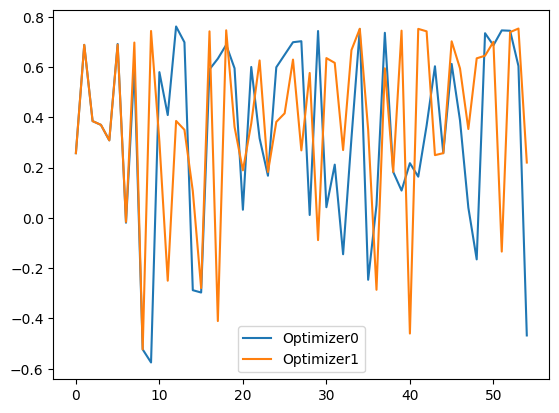

In [36]:
# print(optimizer.max)

import matplotlib.pyplot as plt

for i, optim in enumerate(optimizers[4:]):
    plt.plot(optim.space.target, label=f'Optimizer{i}')

plt.legend()

In [38]:
for i, optim in enumerate(optimizers):
    print(optim.max)


{'target': 0.749662, 'params': {'input_2_features': 14.218913922168952, 'l2_regularization_1': 1e-06, 'l2_regularization_2': 0.09449418830200942, 'learning_rate_1': 0.06034982634335957, 'learning_rate_2': 0.011719621444030558, 'max_bins_1': 51.06357597765116, 'max_bins_2': 73.71156076928844, 'max_iter_1': 179.29574331565556, 'max_iter_2': 537.4576909352497}}
{'target': 0.751174, 'params': {'input_2_features': 16.944888478490512, 'l2_regularization_1': 0.043198336287031666, 'l2_regularization_2': 0.08069321753880584, 'learning_rate_1': 0.020875031424009833, 'learning_rate_2': 0.08336486130860692, 'max_bins_1': 120.2707433398266, 'max_bins_2': 176.3816402331601, 'max_iter_1': 982.0174255359811, 'max_iter_2': 68.96213311337209}}
{'target': 0.753272, 'params': {'input_2_features': 14.274814019729021, 'l2_regularization_1': 0.022805184976055545, 'l2_regularization_2': 0.011939843652504476, 'learning_rate_1': 0.018082633374457386, 'learning_rate_2': 0.011969609968547037, 'max_bins_1': 172.86

In [ ]:
print()
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))